 # Opis notatnika
 Sprawdzenie m.in., czy opóźnienia lotów zależne są od trasy czy warunków pogodowych.

Zaimportowanie bibliotek

In [124]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
username = 'postgres'
password='al2cx7hsixj',  # Przypadkowe, nieprawdziwe hasło
host = 'localhost'
database = 'airlines'
port = 5432

 Tworzenie zmiennej engine, która zostanie użyta do połączenia z bazą danych

In [125]:
url = URL.create(
    "postgresql",
    username="postgres",
    password='al2cx7hsixj',  # Przypadkowe, nieprawdziwe hasło 
    host="localhost",
    database="airlines",
)
engine = create_engine(url)

 Zaczytanie zapisaną wcześniej ramki danych `flight_df` do zmniennej o takiej samej nazwie

In [127]:
flight_df = pd.read_csv(r'C:\Coderslab_Analityk_kurs\Projekt_koncowy\data\processed\flight_df_02.csv')

 # Wzbogacenie o `airport_list`
 Wczytanie do obszaru roboczego tabelę `airport_list` używając procedury `read_sql_table`. Następnie:  
 1. Sprawdzenie, czy klucz `origin_airport_id` jest unikalny.
 1. Jeżeli duplikaty występują, usunięcie ich.  
 1. Złączenie ramek `airport_list_df` wraz z aktualną `flight_df`, używając kolumny `origin_airport_id` oraz złączenia typu `LEFT JOIN`.  
 1. Dodatkowe złączenie ramki `flight_df` z `airport_list_df`, tym razem jednak po kolumnie `destination_airport_id` wraz z `origin_airport_id`.

 Wczytanie ramki `airport_list_df`

In [128]:
airport_list_df = pd.read_sql_table('airport_list', con=engine,)

In [129]:
# Sprawdzenie, czy występują duplikaty:

airport_list_df['origin_airport_id'].duplicated().any()


# False, a więc nie, nie występują

False

 Złączenie ramki `flight_df` oraz `airport_list_df` używając `origin_airport_id`

In [130]:
flight_df = flight_df.merge(airport_list_df, how='left', on='origin_airport_id')

 Złączenie ramki `flight_df` oraz `airport_list_df` używając `destination_airport_id`

In [131]:
flight_df2 = flight_df.merge(airport_list_df, how='left', left_on='dest_airport_id', right_on='origin_airport_id')

In [132]:
# Zmiana nazw kolumn dla większej czytelności:

flight_df2.rename(columns={'origin_city_name_y': 'destination_city_name'}, inplace=True)
flight_df2.rename(columns={'origin_city_name_x': 'origin_city_name'}, inplace=True)
flight_df = flight_df2

 ## Analiza według lotnisk oraz tras
 Polecenia:  
 1. Wyznaczenie lotnisk, z których **odlatywało** najwięcej samolotów.
 1. Wyznaczenie lotniska, na których najwięcej lotów **się kończyło**.  
 1. Wyznaczenie najczęściej uczęszczanej trasy.  
 1. Przy założeniu, że reprezentatywna liczba lotów na trasie wynosi ponad 500, wyznaczenie dodatkowo top 10:  
     - tras z **najmniejszym odsetkiem opóźnień**,  
     - tras z **największym odsetkiem opóźnień**,

In [134]:
# Wyznaczenie lotnisk, z których **odlatywało** najwięcej samolotów:

top_airports_origin_df = flight_df[['origin_airport_id_x', 'id']].groupby('origin_airport_id_x').count()


# Połączenie w celu dodania kolumn z nazwami portów, a nie tylko nr id

top_airports_origin_df = top_airports_origin_df.merge(airport_list_df, 
                                                      how='left', 
                                                      left_on='origin_airport_id_x', 
                                                      right_on='origin_airport_id')

top_airports_origin_df.rename(columns={'id_x': 'Amount_of_flights'}, inplace=True)
top_airports_origin_df.drop(columns=['id_y', 'name'])
top_airports_origin_df = top_airports_origin_df.sort_values('Amount_of_flights', ascending=False)

In [135]:
# Wyznaczenie lotniska, na których najwięcej lotów **się kończyło**:

top_airports_destination_df = flight_df[['dest_airport_id', 'id']].groupby('dest_airport_id').count()
top_airports_destination_df.rename(columns={'id': 'Amount_of_flights'}, inplace=True)
top_airports_destination_df = top_airports_destination_df.sort_values('Amount_of_flights', ascending=False)

In [136]:
# Wyznaczenie najczęściej uczęszczanej trasy:

top_route_df = flight_df[['origin_airport_id_x',
                          'dest_airport_id',
                          'id',
                          'is_delayed']].groupby(['origin_airport_id_x','dest_airport_id'], as_index=False).count()

# Połączenie w celu dodania kolumn z nazwami portów, a nie tylko nr id:

# Nazwy portów z których był wylot:
top_route_df1 = top_route_df.merge(airport_list_df, 
                                                      how='left', 
                                                      left_on='origin_airport_id_x', 
                                                      right_on='origin_airport_id')
#Zmiana nazwy kolumny, aby się nie dublowała:
top_route_df1.rename(columns={'origin_airport_id_x': 'origin_airport_id_source'}, inplace=True)

#Nazwy portów do których odbywały się loty:
top_route_df2 = top_route_df1.merge(airport_list_df, 
                                                      how='left', 
                                                      left_on='dest_airport_id', 
                                                      right_on='origin_airport_id')


#Zmiana nazw i wybranie tylko potrzebnych kolumn:

top_route_df2 = top_route_df2[['origin_airport_id_source',
                               'dest_airport_id',
                               'id_x',
                               'is_delayed',
                               'origin_city_name_x',
                               'origin_city_name_y']]

top_route_df2.rename(columns={'id_x': 'amount_of_flights',
                              'origin_city_name_y': 'destination_city_name'}, inplace=True)


#Dodanie kolumny z odsetkiem opóźnionych lotów:

top_route_df2['delays'] = (top_route_df2['is_delayed'] / top_route_df2['amount_of_flights']).round(2)


#Sortowanie pod względem liczby lotów:

top_route_df2 = top_route_df2.sort_values('amount_of_flights', ascending=False)

In [137]:
# Wprowadzenie założenia, że reprezentatywna liczba lotów na trasie wynosi ponad 500:

top_route_df2 = top_route_df2.loc[top_route_df2['amount_of_flights'] > 500]


In [138]:
# Wyznaczenie tras z najmniejszym odsetkiem opóźnień.

least_route_delays_df = top_route_df2.sort_values('delays', ascending=True).head(10)

least_route_delays_df  # Wizualne sprawdzenie wyniku

,origin_airport_id_source,dest_airport_id,amount_of_flights,is_delayed,origin_city_name_x,destination_city_name,delays
66,12402,12173,5091,266,NaN,"Burbank, CA",0.05
92,12982,12173,6933,375,"Lihue, HI","Burbank, CA",0.05
69,12758,12173,7792,416,"Kona, HI","Burbank, CA",0.05
62,12173,13830,10725,584,"Burbank, CA","Kahului, HI",0.05
61,12173,12982,6940,355,"Burbank, CA","Lihue, HI",0.05
60,12173,12758,7803,450,"Burbank, CA","Kona, HI",0.06
102,13830,12173,10718,688,"Kahului, HI","Burbank, CA",0.06
0,10299,14747,6966,615,"Anchorage, AK","Seattle, WA",0.09
148,14893,14679,5852,643,"Sacramento, CA","San Diego, CA",0.11
127,14492,10397,5275,632,"Raleigh/Durham, NC","Atlanta, GA",0.12


In [139]:
# Wyznaczenie tras z największym odsetkiem opóźnień.

top_route_delays_df = top_route_df2.sort_values('delays', ascending=False).head(10)

top_route_delays_df  # Wizualne sprawdzenie wyniku

,origin_airport_id_source,dest_airport_id,amount_of_flights,is_delayed,origin_city_name_x,destination_city_name,delays
94,13204,11618,6789,2276,"Orlando, FL","Newark, NJ",0.34
45,11292,14771,5520,1769,"Denver, CO","San Francisco, CA",0.32
7,10397,11618,6482,2022,"Atlanta, GA","Newark, NJ",0.31
51,11298,12953,6422,1839,"Dallas/Fort Worth, TX","New York, NY",0.29
117,13930,14771,6256,1795,"Chicago, IL","San Francisco, CA",0.29
22,10721,11618,5588,1602,"Boston, MA","Newark, NJ",0.29
55,11618,10721,5576,1636,"Newark, NJ","Boston, MA",0.29
111,13930,11618,5368,1545,"Chicago, IL","Newark, NJ",0.29
113,13930,12953,14219,3898,"Chicago, IL","New York, NY",0.27
56,11618,13204,6789,1822,"Newark, NJ","Orlando, FL",0.27


 # Wzbogacenie o dane pogodowe
 Wczytanie tabeli `airport_weather` i wykonanie następujących poleceń:  
 1. Obcięcie ramki do kolumn: `['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']`.  
 1. Połączenie ramek `airport_list_df` wraz z `airport_weather_df`, aby w wyniku usunąć te wiersze (lotniska), które nie posiadają danych pogodowych.

 Wczytanie ramki `airport_weather`

In [140]:
pd.read_sql_table('airport_weather', con=engine,)

,id,station,name,date,awnd,pgtm,prcp,snow,snwd,tavg,...,wt09,wesd,wt10,psun,tsun,sn32,sx32,tobs,wt11,wt18
0,1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-01,4.70,NaN,0.14,0.0,0.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-02,4.92,NaN,0.57,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-03,5.37,NaN,0.15,0.0,0.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-04,12.08,NaN,1.44,0.0,0.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,2019-01-05,13.42,NaN,0.00,0.0,0.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46221,46222,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-27,3.58,146.0,0.21,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46222,46223,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-28,6.93,1535.0,1.29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46223,46224,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-29,16.55,1408.0,0.02,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46224,46225,USW00014762,"PITTSBURGH ALLEGHENY CO AIRPORT, PA US",2020-03-30,13.42,817.0,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Oczyszczenie ramki `airport_weather_df` z nadmiarowych kolumn

In [141]:
airport_weather_df = pd.read_csv(r'C:\Users\Victus\Desktop\Coderslab_Analityk_kurs\Projekt_koncowy\data\raw\airport_weather.csv')

# Zmiana nazw kolumn na małe litery

airport_weather_df.columns = airport_weather_df.columns.str.lower()


# Kolumny do pozostawienia

col = ['station', 'name', 'date', 'prcp', 'snow', 'snwd', 'tmax', 'awnd']


# Wybranie tylko wskazanych kolumn

airport_weather_df = airport_weather_df.loc[:, col]

 Połączenie ramek `airport_list_df` oraz `airport_weather_df` aktualizując `airport_weather_df`

In [142]:
# Wybranie z airport_list_df tylko interesujących nas kolumn

temp_airport_list_df = airport_list_df[['origin_airport_id', 'name']]


# Połączenie z airport_weather_df 

airport_weather_df = airport_weather_df.merge(temp_airport_list_df, 
                                                      how='left', 
                                                      on='name')


# Usunięcie wierszy z pustymi wartościami w kolumnie origin_airport_id

airport_weather_df = airport_weather_df.dropna(subset=['origin_airport_id'])

 ## Połączenie `airport_weather_df` oraz `flight_df`
 Połączenie ramek `airport_weather_df` oraz `flight_df`

Zrzutowanie kolumny `date` na `DATETIME` w ramce `airport_weather_df`

In [144]:
airport_weather_df['date'] = pd.to_datetime(airport_weather_df['date'])

 Dodanie kolumny `date` w ramce `flight_df`, również typu `DATETIME`.

In [145]:
# Wymagana przez pandas zmiana nazwy kolumny na day:

flight_df.rename(columns={'day_of_month': 'day'}, inplace=True)


# Dodanie wymaganej kolumny:

flight_df['date'] = pd.to_datetime(flight_df[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d')


# Zmiana nazwy kolumny na poprzednią:

flight_df.rename(columns={'day': 'day_of_month'}, inplace=True)


# Zmiana formatu kolumny na DATETIME - bez tego złączenie merge jest niemożliwe:

flight_df['date'] = pd.to_datetime(flight_df['date'])

 Złączenie tabeli `airport_weather_df` oraz `flight_df`

In [146]:
# Klucz użyty do merge - kolumny 'date' i 'origin_airport_id':

flight_df = flight_df.merge(airport_weather_df, 
                                    how='left', 
                                    left_on=['date', 'origin_airport_id_x'],
                                    right_on=['date', 'origin_airport_id'])

# Praca samodzielna
Zbadanie hipotezy o tym, że temperatura maksymalna wpływa na **odsetek** opóźnień lotów (kolumna `tmax`).  

 ## Analiza dla kolumny `tmax`

In [148]:
# Wybór potrzebnych kolumn:

flight_delayed_by_temperature_df = flight_df[['month','year','tmax','is_delayed']]

In [149]:
# Sprawdzenie czy zmienna posiada obserwacje odstające - wyznaczenie percentyli:

per = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
flight_delayed_by_temperature_analysis_df = flight_delayed_by_temperature_df['tmax'].describe(percentiles=per).round(2)


In [150]:
# Wyświetlenie otrzymanyego wyniku:

flight_delayed_by_temperature_analysis_df

# Na podstawie percentyli postanowiono nie usuwać danych. 
# Wydaje się, że podane są w skali Fahrenheita (maks > 100), a więc należy dodać też w skali Celsjusza

count    1051956.00
mean          70.33
std           17.97
min          -10.00
10%           45.00
25%           59.00
50%           72.00
75%           84.00
90%           92.00
95%           95.00
99%          106.00
max          115.00
Name: tmax, dtype: float64

In [151]:
# Rozróżnienie na skalę Fahrenheita i Celsjusza

# Zmiana nazwy istniejącej kolumny

flight_delayed_by_temperature_df.rename(columns={'tmax': 'tmax_fahrenheit'}, inplace=True)

# Dodanie nowej kolumny. Wzór przeliczenia f na c: 5*(x - 32)/9

flight_delayed_by_temperature_df['tmax_celsius'] = (5*(flight_delayed_by_temperature_df['tmax_fahrenheit'] - 32)/9 ).round(1)

C:\Users\Victus\AppData\Local\Temp\ipykernel_2032\1404098225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_delayed_by_temperature_df.rename(columns={'tmax': 'tmax_fahrenheit'}, inplace=True)
C:\Users\Victus\AppData\Local\Temp\ipykernel_2032\1404098225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_delayed_by_temperature_df['tmax_celsius'] = (5*(flight_delayed_by_temperature_df['tmax_fahrenheit'] - 32)/9 ).round(1)


In [152]:
# Wyznaczenie odsetku opóźnień dla lotów samolotami z poszczególnych temperatur:

przedzialy = flight_delayed_by_temperature_df['tmax_celsius'].unique().tolist()
delayed_column = []

for p in przedzialy:
    temp_df = flight_delayed_by_temperature_df.loc[flight_delayed_by_temperature_df['tmax_celsius'] == p]
    
    # Aby uniknąć dzielenia przez 0:
    if len(temp_df) > 0:
        temp_result = (temp_df['is_delayed'].count() / len(temp_df)).round(2)
    else:
        temp_result = 0
        
    # Dopisanie uzyskanego wyniku do listy delayed_column
    delayed_column.append(temp_result)

    
# Utworzenie ramki z obu list

data = {'tmax_celsius': przedzialy, 'delays': delayed_column}    
delays_by_temp_df = pd.DataFrame(data)

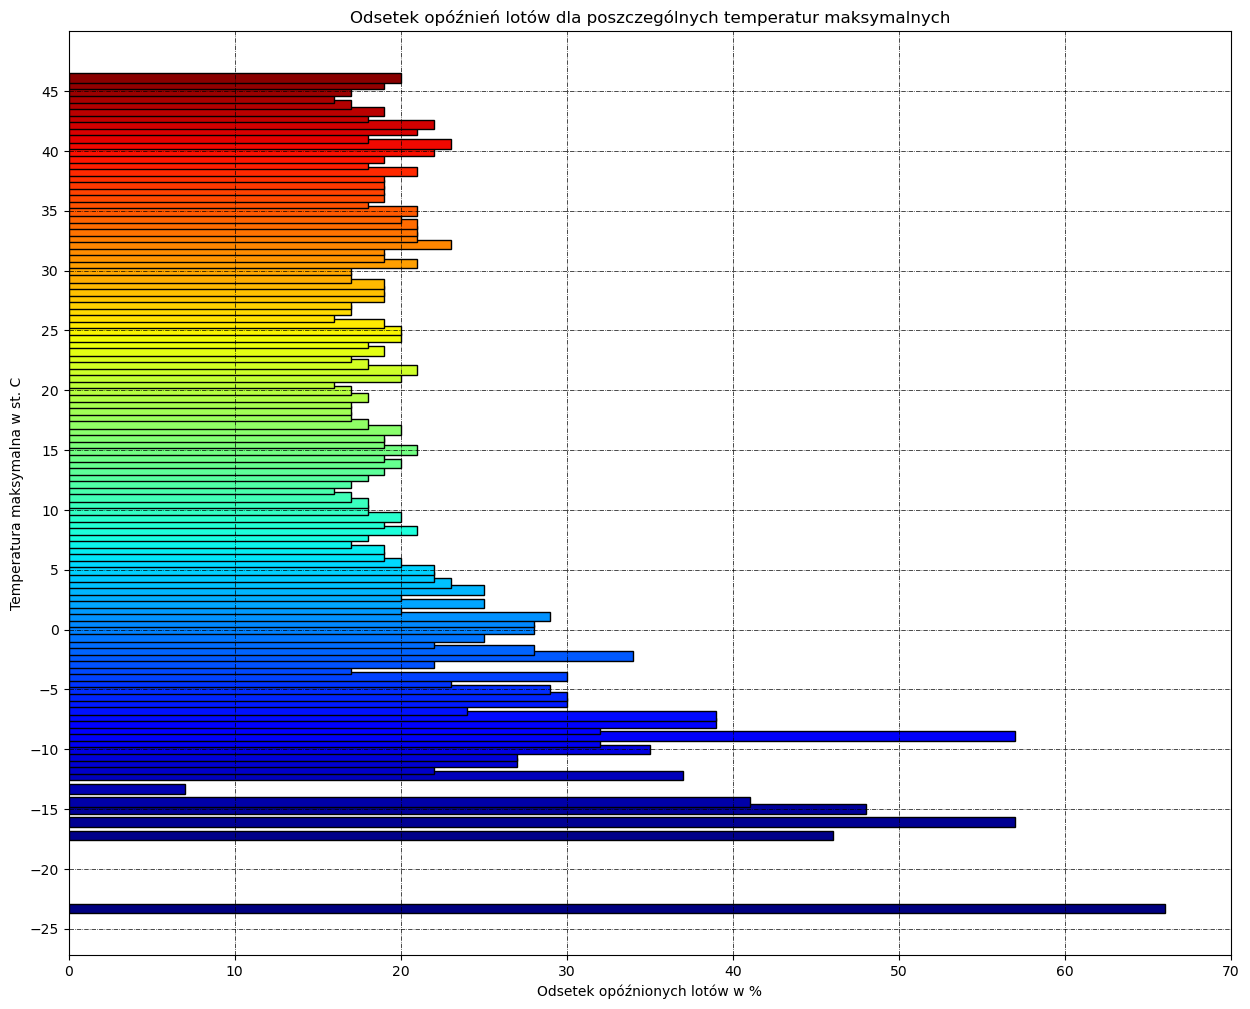

In [153]:
plt.figure(figsize=(15,12))

# Wybranie danych, wraz z posortowaniem dla skali kolorów

df = delays_by_temp_df.sort_values('tmax_celsius', ascending=True)


# Dodanie palety kolorów

colors = plt.cm.jet(np.linspace(0, 1, len(df['tmax_celsius'])))

x = plt.barh(df['tmax_celsius'], df['delays'] * 100, 
             color = colors,
             edgecolor="Black", log=False, label="Odsetek opóźnień")

plt.xlabel('Odsetek opóźnionych lotów w %')
plt.xticks(ticks=range(0, 71, 10))

plt.ylabel('Temperatura maksymalna w st. C')
plt.yticks(ticks=range(-25, 46, 5))

plt.title('Odsetek opóźnień lotów dla poszczególnych temperatur maksymalnych')
plt.grid(which='major', linestyle='-.', linewidth='0.5', color='black')
    
plt.show()

Na podstawie otrzymanych wyników widać, że temperatura może mieć istotny wpływ na opóźnienia lotów. Dotyczy to jednak tylko temperatury poniżej 5 stopni Celsjusza. 

W tym przedziale właśnie występują ekstrema sporządzonego wykresu:
- najniższy odsetek opóźnień (temp. -13 C), 
- najwyższy (temp. -23 C). 
Nie ma tu więc prostej zależności.
    Powyżej temperatury 5 C odsetek opóźnień pozostaje względnie stały w przedziale 16% - 23% i nie wynika wprost z wysokości temperatury. 